## MPAA rating prediction

In [77]:
import pandas as pd
import numpy as np
import warnings
import re
import pickle
import seaborn as sns

%matplotlib inline
warnings.filterwarnings('ignore')

Import dataset :: imdb dataset

In [78]:
from dataset import get_dataframe
dataset = get_dataframe('./dataset_cleaned_emotions')

dataset.head()
dataset.shape

(15455, 41)

In [79]:
## Clean data
dataset.dropna()
dataset.columns = dataset.columns.str.replace(" ", "")
#dataset = dataset[dataset.synopsis != ''] # cannot do this
dataset = dataset[dataset.clean_description != '']
#dataset = dataset[dataset.clean_storyline != '']
dataset.shape

(15455, 41)

## Prepare data

In [80]:
dataset_df = pd.DataFrame()
for index, row in dataset.iterrows():
    try:
        new_row = {
            "Title"    : row["name"],
            "Description" : row["clean_description"],
            "negative" : row["negative"],
            "sadness"  : row["sadness"],
            "trust"    : row["trust"],
            "anger"    : row["anger"],
            "positive" : row["positive"],
            "fear"     : row["fear"],
            "disgust"  : row["disgust"],
            "surprise" : row["surprise"],
            "anticipation"  : row["anticipation"],
            "joy"  : row["joy"],
            "Rating" : row["rating"]
        }
        dataset_df = dataset_df.append( new_row, ignore_index=True )
    except Exception as ex:
        continue

In [81]:
dataset_df = dataset_df[['Title', 'Rating', 'Description']]
dataset_df.columns = dataset_df.columns.str.strip()
dataset_df.head(4)

,Title,Rating,Description
0,The Cellar,PG-13,young boy finds ancient comanche monster spiri...
1,The Cemetery Club,PG-13,lifelong friends meet weekly celebrate past pr...
2,The Challenger,PG-13,struggling bronx mechanic jaden miller uses bo...
3,The Chaperone,PG-13,ex con run criminal past hides ratted chaperon...


In [82]:
# finding unique mpaa rating in the dataset
dataset_df['Rating'].unique()

array(['PG-13', 'PG', 'R', 'G', 'NC-17'], dtype=object)

In [83]:
# clean mpaa ratings
mpaa_fix = {
    'PG-13 ' : 'PG-13',
    'R ' : 'R',
    'PG ': 'PG',
    'G ' : 'G',
    'NR ': 'NR',
    'NC17 ': 'NC17'
}
for i, rating in dataset_df['Rating'].iteritems():
    if rating in mpaa_fix.keys():
        fix_val = mpaa_fix.get(rating)
        dataset_df.iloc[i]['Rating'] = fix_val
dataset_df['Rating'].unique()

array(['PG-13', 'PG', 'R', 'G', 'NC-17'], dtype=object)

In [84]:
# Clean the movie description
def clean_description( text_str ):
    text = re.sub('[^a-zA-Z]',  ' ', text_str)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

for i, description in dataset_df['Description'].iteritems():
    dataset_df.iloc[i]['Description'] = clean_description( str(description) )

## Data Distribution

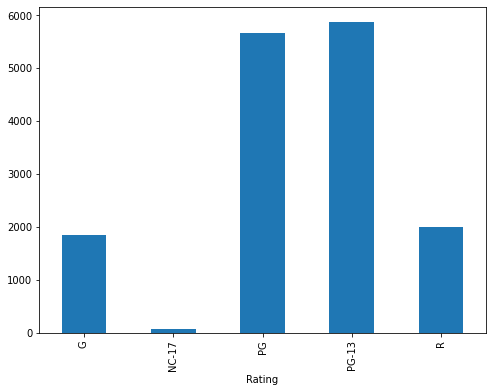

In [85]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
dataset_df.groupby('Rating')['Description'].count().plot.bar(ylim=0)
plt.show()

In [86]:
## drop NC-17
dataset_df = dataset_df[dataset_df.Rating != 'NC-17'] 

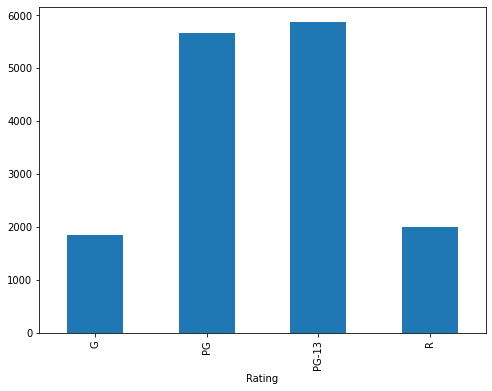

In [87]:
fig = plt.figure(figsize=(8,6))
dataset_df.groupby('Rating')['Description'].count().plot.bar(ylim=0)
plt.show()

## Use same amount of labels

In [88]:
G_count = dataset_df[dataset_df.Rating == 'G'].shape
G_count

(1853, 3)

In [90]:
dataset_df = dataset_df.sample(frac=1).groupby('Rating').head(1853)
dataset_df

,Title,Rating,Description
7345,Pizza Man,PG-13,pizza delivery boy receives superhuman strengt...
7264,Pascali's Island,PG-13,secret agent turkey persuaded superiors assist...
15078,Diaboliquement vôtre,G,wealthy amnesiac begins suspect devoted wife r...
10650,The Pagemaster,G,cowardly boy buries accident statistics enters...
4802,Cannibals and Crampons,PG-13,two british ex army officers set climb unscale...
...,...,...,...
8112,16 Wishes,G,abby made wishes list birthday gets magic cand...
14239,Starbird and Sweet William,G,plane crash survivor draws upon sensibilities ...
14381,The Fox and the Hound,G,little fox named tod copper hound puppy vow be...
15069,De-as fi... Harap Alb,G,add plot


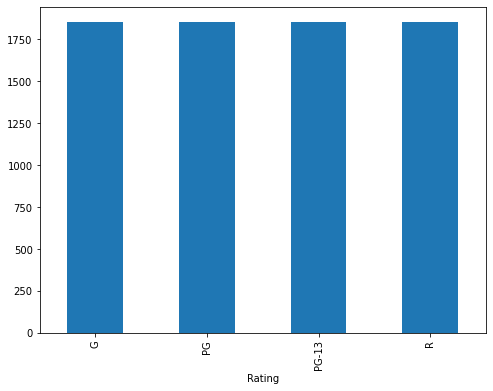

In [92]:
fig = plt.figure(figsize=(8,6))
dataset_df.groupby('Rating')['Description'].count().plot.bar(ylim=0)
plt.show()

In [93]:
pickle.dump(dataset_df, open('./data/dataset_df_imdb_cleaned_n_sample.pkl', 'wb'))

## Training model

In [94]:
training_df = pickle.load( open('./data/dataset_df_imdb_cleaned_n_sample.pkl', 'rb') )

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, LSTM, Embedding, GlobalMaxPooling1D

In [96]:
_y = training_df['Rating']
encoder = LabelEncoder()
Y = encoder.fit_transform(_y)
Y

array([2, 3, 0, ..., 3, 3, 2])

In [97]:
X = training_df['Description']
X

5520     freelance writer looking romance sells story c...
6994     harvard time social upheaval student unrest th...
14318    vernon praiseworthy clumsy lovable dope stands...
8451     two tourists florida attacked chilling group b...
7983     mia sakamoto feels trapped physically verbally...
                               ...                        
13974    old jewish woman african american chauffeur am...
3562     ex con joins forces sexy high priced call girl...
13065    six college students discover dorm insane asyl...
3767     mike anderson senior quintessential new englan...
10308    grieving untimely loss family dissociative sta...
Name: Description, Length: 7412, dtype: object

## Train, test split

In [98]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.3, random_state=40 )

In [99]:
Y_train = to_categorical(Y_train)
Y_test  = to_categorical(Y_test)

In [100]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

In [101]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test  = tokenizer.texts_to_sequences(X_test)

In [102]:
vocabulary_size = len(tokenizer.word_index) + 1
maxlen = 400 # Only concider first 400 words of each description

X_train = pad_sequences( X_train, maxlen=maxlen )
X_test  = pad_sequences( X_test, maxlen=maxlen )

## Use GloVe : Global Vectors for Word Representation
https://nlp.stanford.edu/projects/glove/

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. 

In [103]:
glove_file = open('./glove.6B/glove.6B.100d.txt', encoding='utf8')

In [104]:
embedd_dictionary = dict()
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dims = np.asarray(records[1:], dtype='float32')
    embedd_dictionary[word] = vector_dims

glove_file.close()

In [105]:
embedd_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    embedd_vector = embedd_dictionary.get(word)
    if embedd_vector is not None:
        embedd_matrix[index] = embedd_vector

## Build the NN Model

In [106]:
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=100, weights=[embedd_matrix], trainable=False))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1531700   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 516       
Total params: 1,649,464
Trainable params: 117,764
Non-trainable params: 1,531,700
_________________________________________________________________


In [107]:
hist = model.fit(X_train, Y_train, batch_size=128, epochs=40, validation_split=0.30, verbose=1)

Epoch 1/40
29/29 [==============================] - 20s 636ms/step - loss: 1.3760 - accuracy: 0.2925 - val_loss: 1.2672 - val_accuracy: 0.4053
Epoch 2/40
29/29 [==============================] - 19s 662ms/step - loss: 1.2788 - accuracy: 0.4025 - val_loss: 1.2524 - val_accuracy: 0.4027
Epoch 3/40
29/29 [==============================] - 20s 693ms/step - loss: 1.2402 - accuracy: 0.4380 - val_loss: 1.2683 - val_accuracy: 0.4053
Epoch 4/40
29/29 [==============================] - 19s 660ms/step - loss: 1.2265 - accuracy: 0.4265 - val_loss: 1.2924 - val_accuracy: 0.3924
Epoch 5/40
29/29 [==============================] - 19s 649ms/step - loss: 1.2129 - accuracy: 0.4340 - val_loss: 1.2375 - val_accuracy: 0.4245
Epoch 6/40
29/29 [==============================] - 19s 655ms/step - loss: 1.1805 - accuracy: 0.4535 - val_loss: 1.2408 - val_accuracy: 0.4194
Epoch 7/40
29/29 [==============================] - 19s 660ms/step - loss: 1.1583 - accuracy: 0.4772 - val_loss: 1.2695 - val_accuracy: 0.3899

In [108]:
loss, acc = model.evaluate(X_test, Y_test, verbose=1)
print('loss: ', loss)
print('accuracy: ', acc)

70/70 [==============================] - 4s 55ms/step - loss: 2.3185 - accuracy: 0.3669
loss:  2.3185489177703857
accuracy:  0.36690646409988403


## Save model and tokenizer

In [109]:
# save model
model.save('./data/mpaa_classifier_imdb_n_sample.h5')

# save word tokenizer
pickle.dump(tokenizer, open('./data/tokenizer_imdb_n_sample.pkl', 'wb'))

## Metrics

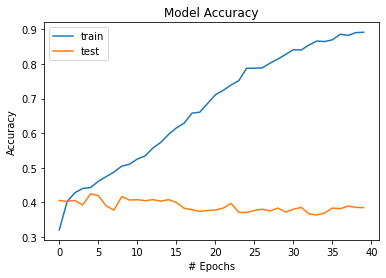

In [110]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('# Epochs')
plt.legend(['train', 'test'])
plt.show()

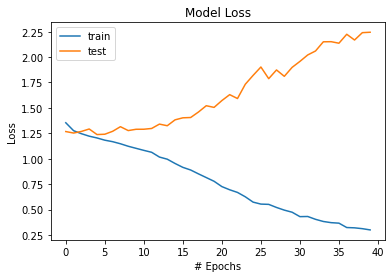

In [111]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('# Epochs')
plt.legend(['train', 'test'])
plt.show()